# Taxonomy classification

Author: **Anna Toidze**

In this Jupyter Notebook we analyze the taxonomy of the provided samples. That means that we will identify the organisms present in our samples by exploration of the 16S rRNA gene sequence data and the taxonomy assignment of the features into bacterial species.

**Notebook overview:**<br>
[1. Setup](#setup)<br>
[2. Taxonomy assignment](#tax_assignment_main)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Reference database construction](#ref_db)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Training taxonomy classifier](#train_classifier)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.3 Taxonomy assignment](#tax_assignment)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.4 Taxonomy visualization](#tax_visualization)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.5 Exploring feature data with pandas](#yay_pandas)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.6 Plotting the taxonomy](#plotting)<br>

We will be following the following [tutorial](!https://forum.qiime2.org/t/processing-filtering-and-evaluating-the-silva-database-and-other-reference-sequence-data-with-rescript/15494?u=nicholas_bokulich) and also using the exercise from W4 as a reference.

<a id='setup'></a>

## 1. Setup

The cell below will import all the packages required in the downstream analyses as well as set all the necessary variables and data paths.

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as x
import numpy as np

import qiime2 as q2

%matplotlib inline

In [3]:
# assigning variables throughout the notebook

# location of this week's data and all the results produced by this notebook
# - this should be a path relative to your working directory
raw_data_dir = "../data/raw"
data_dir = "../data/processed"
vis_dir  = "../results"

<a id='tax_assignment_main'></a>

## 2. Taxonomy assignment

We will use a machine learning classifier trained on a reference database to classify the corresponding species. Here, we will be using the SILVA database [3], which targets bacterial rRNA genes, is curated by experts and contains uncultured sequences, which could be useful for our research. We will construct a reference database to train the classifier on it and then use it to identify our species. 


<a id='ref_db'></a>

### 2.1 Reference database construction

In this step, we will:

- Retrieve the SILVA 16S RefSeqs database (**v. 138.1**) using the `RESCRIPt` plugin
- Refine the database by removing sequences of potentially lower quality
- Extract the target region from the 16S rRNA gene, based on the primers used for amplifying the NGS library

**About RESCRIPt:**  
`RESCRIPt` (Reference Sequence Annotation and Curation Pipeline) is a Python package and QIIME 2 plugin designed for formatting, managing, and curating sequence reference databases. It supports the assembly, modification, and evaluation of databases from sources like SILVA, NCBI, Greengenes, and GTDB, and aids in creating reference databases for use with QIIME 2 or other microbiome analysis software and taxonomy classifiers.

There is an easy way to create a reference database, which in gritty details would include: 

- downloading Taxonomy rank, Taxonomy map, Taxonomy tree files and SILVA NR99 sequences (non-redundant and unaligned).
- importing all of these files into QIIIME 2
- reverse transribing the RNA sequences stored in SILVA database (`FeatureData[RNASequence]`) to DNA (`FeatureData[DNASequence]`)
- preparing the silva taxonomy by uniting all the Taxonomy files.
  
Thankfully, we could skip all of the individual steps (except reverse transription) by the following command (but individual steps can be looked up in the cited tutorial). 

#### 2.1.1 Data download

In [4]:
! qiime rescript get-silva-data \
    --p-version '138.1' \
    --p-target 'SSURef_NR99' \
    --o-silva-sequences $data_dir/silva-138.1-ssu-nr99-rna-seqs.qza \
    --o-silva-taxonomy $data_dir/silva-138.1-ssu-nr99-tax.qza

536.75s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Saved FeatureData[RNASequence] to: ../data/raw/silva-138.1-ssu-nr99-rna-seqs.qza
Saved FeatureData[Taxonomy] to: ../data/raw/silva-138.1-ssu-nr99-tax.qza


The data in SILVA is stored as RNA sequences, imported as `FeatureData[RNASequence]`. To ensure compatibility in downstream processes, we’ll convert the data to `FeatureData[DNASequence]` as follows:

In [6]:
! qiime rescript reverse-transcribe \
    --i-rna-sequences $data_dir/silva-138.1-ssu-nr99-rna-seqs.qza \
    --o-dna-sequences $data_dir/silva-138.1-ssu-nr99-seqs.qza

717.13s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Saved FeatureData[Sequence] to: ../data/raw/silva-138.1-ssu-nr99-seqs.qza


#### 2.1.2 Database curation

##### Culling
In this step, we’re “culling” low-quality sequences using `cull-seqs`. Specifically, we’ll filter out sequences containing 5 or more ambiguous bases (IUPAC-compliant ambiguity codes) and any homopolymers with a length of 8 or more bases.

In [8]:
! qiime rescript cull-seqs \
    --i-sequences $data_dir/silva-138.1-ssu-nr99-seqs.qza \
    --o-clean-sequences $data_dir/silva-138.1-ssu-nr99-seqs-cleaned.qza

865.12s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Saved FeatureData[Sequence] to: ../data/raw/silva-138.1-ssu-nr99-seqs-cleaned.qza


##### Filtering sequences by length and taxonomy

Instead of applying a uniform length filter across all reference sequences, we’ll filter based on taxonomy to avoid bias. For example, removing sequences shorter than 1000 or 1200 bp would disproportionately eliminate many Archaea and some Bacteria sequences, potentially increasing retention of shorter, lower-quality Bacterial or Eukaryal sequences, leading to selection bias in the database. To address this, we’ll filter sequences by length criteria specific to each taxonomic group: Archaea (16S) ≥ 900 bp, Bacteria (16S) ≥ 1200 bp, and Eukaryota (18S) ≥ 1400 bp. Refer to the help text for more details.

In [9]:
! qiime rescript filter-seqs-length-by-taxon \
    --i-sequences $data_dir/silva-138.1-ssu-nr99-seqs-cleaned.qza \
    --i-taxonomy $data_dir/silva-138.1-ssu-nr99-tax.qza \
    --p-labels Archaea Bacteria Eukaryota \
    --p-min-lens 900 1200 1400 \
    --o-filtered-seqs $data_dir/silva-138.1-ssu-nr99-seqs-filt.qza \
    --o-discarded-seqs $data_dir/silva-138.1-ssu-nr99-seqs-discard.qza 


1157.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Saved FeatureData[Sequence] to: ../data/raw/silva-138.1-ssu-nr99-seqs-filt.qza
Saved FeatureData[Sequence] to: ../data/raw/silva-138.1-ssu-nr99-seqs-discard.qza


##### Dereplicating Sequences and Taxonomy
According to the notes on the SILVA 138.1 NR99 842 release, there may be identical full-length sequences with either the same or different taxonomies. To streamline the data before further processing, we’ll first dereplicate it, removing redundant sequence entries. We’ll use the default `uniq` mode here, which retains identical sequences even if they have different taxonomies. 

In [10]:
! qiime rescript dereplicate \
    --i-sequences $data_dir/silva-138.1-ssu-nr99-seqs-filt.qza  \
    --i-taxa $data_dir/silva-138.1-ssu-nr99-tax.qza \
    --p-mode 'uniq' \
    --o-dereplicated-sequences $data_dir/silva-138.1-ssu-nr99-seqs-derep-uniq.qza \
    --o-dereplicated-taxa $data_dir/silva-138.1-ssu-nr99-tax-derep-uniq.qza

1308.42s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Saved FeatureData[Sequence] to: ../data/raw/silva-138.1-ssu-nr99-seqs-derep-uniq.qza
Saved FeatureData[Taxonomy] to: ../data/raw/silva-138.1-ssu-nr99-tax-derep-uniq.qza


##### Fit classifier

This is not an amplicon-region specific classifier, but could be used for other purposes. 

In [11]:
! qiime feature-classifier fit-classifier-naive-bayes \
  --i-reference-reads  $data_dir/silva-138.1-ssu-nr99-seqs-derep-uniq.qza \
  --i-reference-taxonomy $data_dir/silva-138.1-ssu-nr99-tax-derep-uniq.qza \
  --o-classifier $data_dir/silva-138.1-ssu-nr99-classifier.qza

1453.91s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Saved TaxonomicClassifier to: ../data/raw/silva-138.1-ssu-nr99-classifier.qza


#### 2.1.3 Creating an Amplicon-Region Specific Classifier by PCR-region extraction



Creating an Amplicon-Region Specific Classifier
In this section, we’ll cover how to build an amplicon-specific classifier, which enables more accurate taxonomic classification of sequencing data (Werner et al. 2011, Bokulich et al. 2018). To achieve this, we’ll use the same primer sequences from our PCR/sequencing to extract the targeted amplicon region from the reference database. Following primers in the 5'-3' direction were used for amplification:

- Forward primer: ACTCCTRCGGGAGGCAGCAG
- Reverse primer: GGACTACHVGGGTATCTAATCCTGT

We’ll extract this amplicon region from our pre-filtered full-length sequences. Additionally, we’ll set --p-read-orientation 'forward', aligning with the forward-curated orientation of the SILVA database, which allows for quicker processing without accounting for mixed orientations during primer search.

Since classifiers perform best when trained on data that precisely matches the amplicon region used for later identification, extracting this region from the full RNA sequences in the database is crucial. Primer sequences can also be located in experiment metadata, such as through the SRA Run Selector for additional details.

In [32]:
!qiime feature-classifier extract-reads \
    --i-sequences  $data_dir/silva-138.1-ssu-nr99-seqs-derep-uniq.qza \
    --p-f-primer ACTCCTRCGGGAGGCAGCAG \
    --p-r-primer GGACTACHVGGGTATCTAATCCTGTT \
    --p-n-jobs 8 \
    --p-read-orientation 'forward' \
    --o-reads  $data_dir/silva-138.1-ssu-nr99-seqs-515f-806r.qza

85454.64s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Saved FeatureData[Sequence] to: ../data/processed/silva-138.1-ssu-nr99-seqs-515f-806r.qza


##### Dereplicating the Extracted Region
Although we previously dereplicated the full-length sequences, we’ll repeat this step because the extracted amplicon regions may now be identical across shorter sequences. This process will reduce the database size by removing redundant entries where different full-length sequences now share identical taxonomy in the extracted region.

Some unique sequences may also correspond to different taxonomies (e.g., at the genus level) after extraction, requiring us to choose an appropriate handling method. We can manage these cases by selecting one of the available --p-mode options to guide the taxonomy assignment for these sequences.

In [33]:
! qiime rescript dereplicate \
    --i-sequences $data_dir/silva-138.1-ssu-nr99-seqs-515f-806r.qza \
    --i-taxa $data_dir/silva-138.1-ssu-nr99-tax-derep-uniq.qza \
    --p-threads 8 \
    --p-mode 'uniq' \
    --o-dereplicated-sequences $data_dir/silva-138.1-ssu-nr99-seqs-515f-806r-uniq.qza \
    --o-dereplicated-taxa  $data_dir/silva-138.1-ssu-nr99-tax-515f-806r-derep-uniq.qza

85658.98s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Saved FeatureData[Sequence] to: ../data/processed/silva-138.1-ssu-nr99-seqs-515f-806r-uniq.qza
Saved FeatureData[Taxonomy] to: ../data/processed/silva-138.1-ssu-nr99-tax-515f-806r-derep-uniq.qza


<a id='train_classifier'></a>

### 2.2 Training taxonomy classifier

We’re now ready to train our machine learning classifier using the extracted, dereplicated reads as inputs and their corresponding taxonomies as outputs. We will train a Naive Bayes classifier, known for its strong classification performance and low computational cost.

In [34]:
! qiime feature-classifier fit-classifier-naive-bayes \
    --i-reference-reads $data_dir/silva-138.1-ssu-nr99-seqs-515f-806r-uniq.qza \
    --i-reference-taxonomy $data_dir/silva-138.1-ssu-nr99-tax-515f-806r-derep-uniq.qza \
    --p-classify--chunk-size 4000 \
    --o-classifier $data_dir/silva-138.1-ssu-nr99-515f-806r-classifier.qza # \
    # if [ ! $? -eq 0 ]; then echo "Command failed - most likely reason is not enough memory."; fi

85736.71s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Saved TaxonomicClassifier to: ../data/processed/silva-138.1-ssu-nr99-515f-806r-classifier.qza


<a id='tax_assignment'></a>

### 2.3 Taxonomy Assignment

We’re now prepared to assign taxonomy labels to the ASVs from data download and preprocessing. To do this, we will use the `classify-sklearn` action from the `feature-classifier` plugin. This action requires two inputs:

- The classifier trained in the previous step
- The sequences to be classified

This process will utilize the `FeatureData[Sequence]` artifact containing our ASVs which we generated in the previous notebook `01_data_download_and_preprocessing.ipynb`.

In [35]:
! qiime feature-classifier classify-sklearn \
    --i-classifier $data_dir/silva-138.1-ssu-nr99-515f-806r-classifier.qza  \
    --i-reads $data_dir/rep-seqs.qza \
    --o-classification $data_dir/taxonomy.qza

86050.58s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Saved FeatureData[Taxonomy] to: ../data/processed/taxonomy.qza


<a id='tax_visualization'></a>

### 2.4 Taxonomy Visualization

Now, let’s examine the composition of our samples. We can start by creating a tabular representation of all the features along with their corresponding taxonomy labels:

In [36]:
! qiime metadata tabulate \
    --m-input-file $data_dir/taxonomy.qza \
    --o-visualization $data_dir/taxonomy.qzv

86067.95s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Saved Visualization to: ../data/processed/taxonomy.qzv


In [ ]:
! qiime tools view $data_dir/taxonomy.qzv

##### Barplotting

In [37]:
! qiime taxa barplot \
    --i-table $data_dir/table.qza \
    --i-taxonomy $data_dir/taxonomy.qza \
    --m-metadata-file $data_dir/metadata.tsv\
    --o-visualization $data_dir/taxa-bar-plots.qzv

86079.55s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Saved Visualization to: ../data/processed/taxa-bar-plots.qzv


In [54]:
! qiime tools view $data_dir/taxa-bar-plots.qzv

156287.36s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

### Filtering feature tables and sequences based on taxonomy annotations


We need to filter out sequences, classified only to the phylum or class level, as these are often non-target sequences (e.g., host or dietary DNA traces) and potential contaminants. In host-associated microbiome samples, typical contaminants include mitochondria and chloroplasts. Here, we also discovered Unassigned class, which we exclude. 

This filtering process can be applied by providing the feature table and the taxonomic annotations created earlier. To include only specific features, the `--p-include` parameter specifies that an annotation must contain the prefix `c__`, which in the SILVA taxonomy denotes class-level assignments. Any taxonomic labels lacking c__ will thus be assigned to the phylum level at most. Additionally, this filter will exclude features labeled only with c__ (indicating that no named class was assigned) and annotations containing "Chloroplast" or "Mitochondria" (which correspond to organelle 16S sequences) or "Unassigned".



In [9]:
! qiime taxa filter-table \
    --i-table $data_dir/table.qza \
    --i-taxonomy $data_dir/taxonomy.qza \
    --p-exclude Unassigned,mitochondria,chloroplast \
    --p-include c__ \
    --o-filtered-table $data_dir/table-filtered.qza

! qiime taxa filter-seqs \
    --i-sequences $data_dir/rep-seqs.qza \
    --i-taxonomy $data_dir/taxonomy.qza \
    --p-exclude Unassigned,mitochondria,chloroplast \
    --p-include c__ \
    --o-filtered-sequences $data_dir/rep-seqs-filtered.qza

Saved FeatureTable[Frequency] to: ../data/processed/table-filtered.qza
Saved FeatureData[Sequence] to: ../data/processed/rep-seqs-filtered.qza


In [ ]:
! qiime taxa barplot \
    --i-table $data_dir/table-filtered.qza \
    --i-taxonomy $data_dir/taxonomy.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --o-visualization $data_dir/taxa-bar-plots-filtered.qzv

Saved Visualization to: ../data/processed/taxa-bar-plots-filtered.qzv


In [4]:
!qiime tools view $data_dir/taxa-bar-plots-filtered.qzv

Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

<a id='yay_pandas'></a>

### 2.5 Exploring feature data with pandas

In [157]:
# first let's increase the displayed column width, as some of the taxonomy annotations
# are quite long and get cut off in the default display.
pd.set_option('max_colwidth', 150)

In [158]:
# note: QIIME 2 artifact files can be loaded as python objects! This is how.
taxa = q2.Artifact.load(f'{data_dir}/taxonomy.qza')
# view as a `pandas.DataFrame`. Note: Only some Artifact types can be transformed to DataFrames
taxa = taxa.view(pd.DataFrame)

In [227]:
taxa.head(10)

,Taxon,Confidence
Feature ID,,
65c81b7f020fa6530e5995cfadbed4b8,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia;s__,0.995352999769101
3b5167fc05d221e402cb1748506b8442,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia;s__,0.9947820597188002
8b03f72e05e140685a739928d4dd2619,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia;s__,0.9806855368923134
dc5e130892eb358854eb477a790f8af9,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__,0.999971217732479
9b4ec0ce1b21a5a1172c2f0452d9f241,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;s__,0.9999999999999716
20898187149c3e7f0a482709960f130b,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Dorea;s__,0.9938838415196969
43ead7aa9cfdad4f483a1ddabe1b3a6e,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcaceae;g__Intestinibacter;s__,0.9886554004334034
0182133cb1244e92ed02de4137f6c59b,d__Bacteria;p__Firmicutes;c__Clostridia;o__Peptostreptococcales-Tissierellales;f__Peptostreptococcaceae;g__Terrisporobacter;s__,0.9992741070800925
ab77d8f021728a5119d41179672e75a4,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter;s__,0.9634819981564366


In [160]:
taxa_sorted = taxa.sort_values("Confidence")

In [228]:
taxa_sorted.head(10)

,Taxon,Confidence
Feature ID,,
54c6ab0b1570dd0525a2df10fd0145b1,Unassigned,0.3227778646543433
f8b597d22528ccd009b7c4f2f7f0505c,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Ruminococcus]_torques_group;s__,0.7017845359587578
c8703d3d624bdfd6fa70431bf6ec2d5d,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Roseburia;s__,0.703102058263672
1a7ef7798d546edecfebaa16a2829d18,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Ruminococcus]_torques_group;s__,0.7045141750825356
3fcd4da087ffe0a4aadbae49375a8515,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter;s__,0.7052001288123767
1d93bce7d29167e61e7c1cabe53c2cea,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__HT002;s__,0.7067161140679239
ef797d55874dd0d4ed8ea1f88ac59b2f,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Lachnospiraceae_NC2004_group;s__,0.7078966731383076
75730470e54af58658e4eadc1d0b68a2,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Ruminococcus]_torques_group;s__,0.7083037503745344
48f7ff44391288a646e1e268ef7e2111,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia;s__,0.7128043085269679


In [231]:
!qiime tools view $data_dir/rep-seqs.qzv

242814.22s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

Blasting `54c6ab0b1570dd0525a2df10fd0145b1` led to it being classified definitely as part of human mitochondrial genome

In [230]:
taxa_sorted[~taxa_sorted["Taxon"].str.contains("p__")]

,Taxon,Confidence
Feature ID,,
cb7115deb3a45689469e82d8dd81e316,d__Bacteria,0.9999999999996786


Blasing `cb7115deb3a45689469e82d8dd81e316` led it to being mapping to uncultured bacteria.

Merging the taxonomy annotations with the Feature table.

In [13]:
features = q2.Artifact.load(f"{data_dir}/table-filtered.qza")
features = features.view(pd.DataFrame).transpose()
features

,EG0024,EG0031,EG0039,EG0055,EG0057,EG0070,EG0088,EG0101,EG0118,EG0136,...,EG2473,EG2490,EG2518,EG2537,EG2559,EG2580,EG2591,EG2608,EG2638,EG2659
d94fb3fc25e2729d82ee24c1b9f1407d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33651fe2ea434f81d16cf092202d31bd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a0252397b5bdf30aa5d7c19c324c51c5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f715f87fd778c82695f2614f29bb7eb0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a3412af8f44bfe6926a9e9f8e165b516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0bbb8cf5b1158486a106d38bb3aa9d3d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2953b6b34d6eec95798f65a673829158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9098fc35f29a9086e70ecff02788ff25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79fa22765505a417b5beef1a3ed0e729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [221]:
df = pd.concat([taxa, features], axis=1, join='inner')

<a id='plotting'></a>

### 2.6 Plotting the taxonomy

In [224]:
def plot_taxonomic_abundance(df, ranks, color_map='Accent', sort_target='Firmicutes'):
    """
    Plots relative abundance stacked bar plots for each taxonomic rank in ranks.
    
    Parameters:
    - df: DataFrame containing taxonomic data with a 'Taxon' column and abundance columns for each sample.
    - ranks: List of taxonomic ranks to extract and plot (e.g., ["Phylum", "Class", "Order", "Family", "Genus", "Species"]).
    - color_map: Colormap to use for distinct colors (default is 'Accent').
    - sort_target: The taxonomic entry to use for sample sorting (default is 'Firmicutes').
    """
    # Extract each taxonomic rank from the 'Taxon' column
    for rank in ranks:
        df[rank] = df['Taxon'].str.extract(rf'{rank[:1].lower()}__([^;]+)')

    # Define a color palette using the specified color map
    colors = cm.get_cmap(color_map).colors
    
    # Loop over each taxonomic rank and generate the plot
    for rank in ranks:
        # Prepare data for the specific rank by dropping other rank columns
        data_for_plot = df.reset_index(drop=True).drop(columns=['Taxon', 'Confidence'] + [r for r in ranks if r != rank])

        # Sum values by the current rank level for each sample
        rank_sums = data_for_plot.groupby(rank).sum()

        # Convert to relative abundance for each sample
        rank_relative = rank_sums.div(rank_sums.sum(axis=0), axis=1) * 100

        # Sort samples by the abundance of the specified sort_target (e.g., 'Firmicutes') if available
        if sort_target in rank_relative.index:
            sorted_samples = rank_relative.loc[sort_target].sort_values(ascending=True).index
        else:
            sort_target = rank_relative.sum(axis=1).sort_values(ascending=False).index[0]
            sorted_samples = rank_relative.loc[sort_target].sort_values(ascending=True).index
        rank_relative_sorted = rank_relative[sorted_samples]

        # Order rank indices based on total abundance across all samples
        rank_total_abundance = rank_relative_sorted.sum(axis=1)
        rank_order = rank_total_abundance.sort_values(ascending=True).index
        rank_relative_sorted = rank_relative_sorted.reindex(rank_order)

        # Map colors to the ordered indices (reverse order for a visual gradient)
        rank_colors = {entry: colors[i % len(colors)] for i, entry in enumerate(rank_order[::-1])}

        # Plot with specified colormap colors for the current rank
        plt.figure(figsize=(15, 8))
        rank_relative_sorted.T.plot(
            kind='bar', stacked=True, figsize=(20, 10), width=0.8, 
            color=[rank_colors[entry] for entry in rank_relative_sorted.index]
        )
        plt.xlabel("Sample", fontsize=14)
        plt.ylabel("Relative Abundance (%)", fontsize=14)
        plt.title(f"Relative Abundance of {rank} Across Samples", fontsize=18)
        plt.legend(title=rank, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(f"{vis_dir}/taxa-bar-plots-{rank}.png")

/var/folders/5x/72bglw1x1178wdf5_zjmlpjw0000gn/T/ipykernel_27527/3850872949.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap(color_map).colors


<Figure size 1500x800 with 0 Axes>

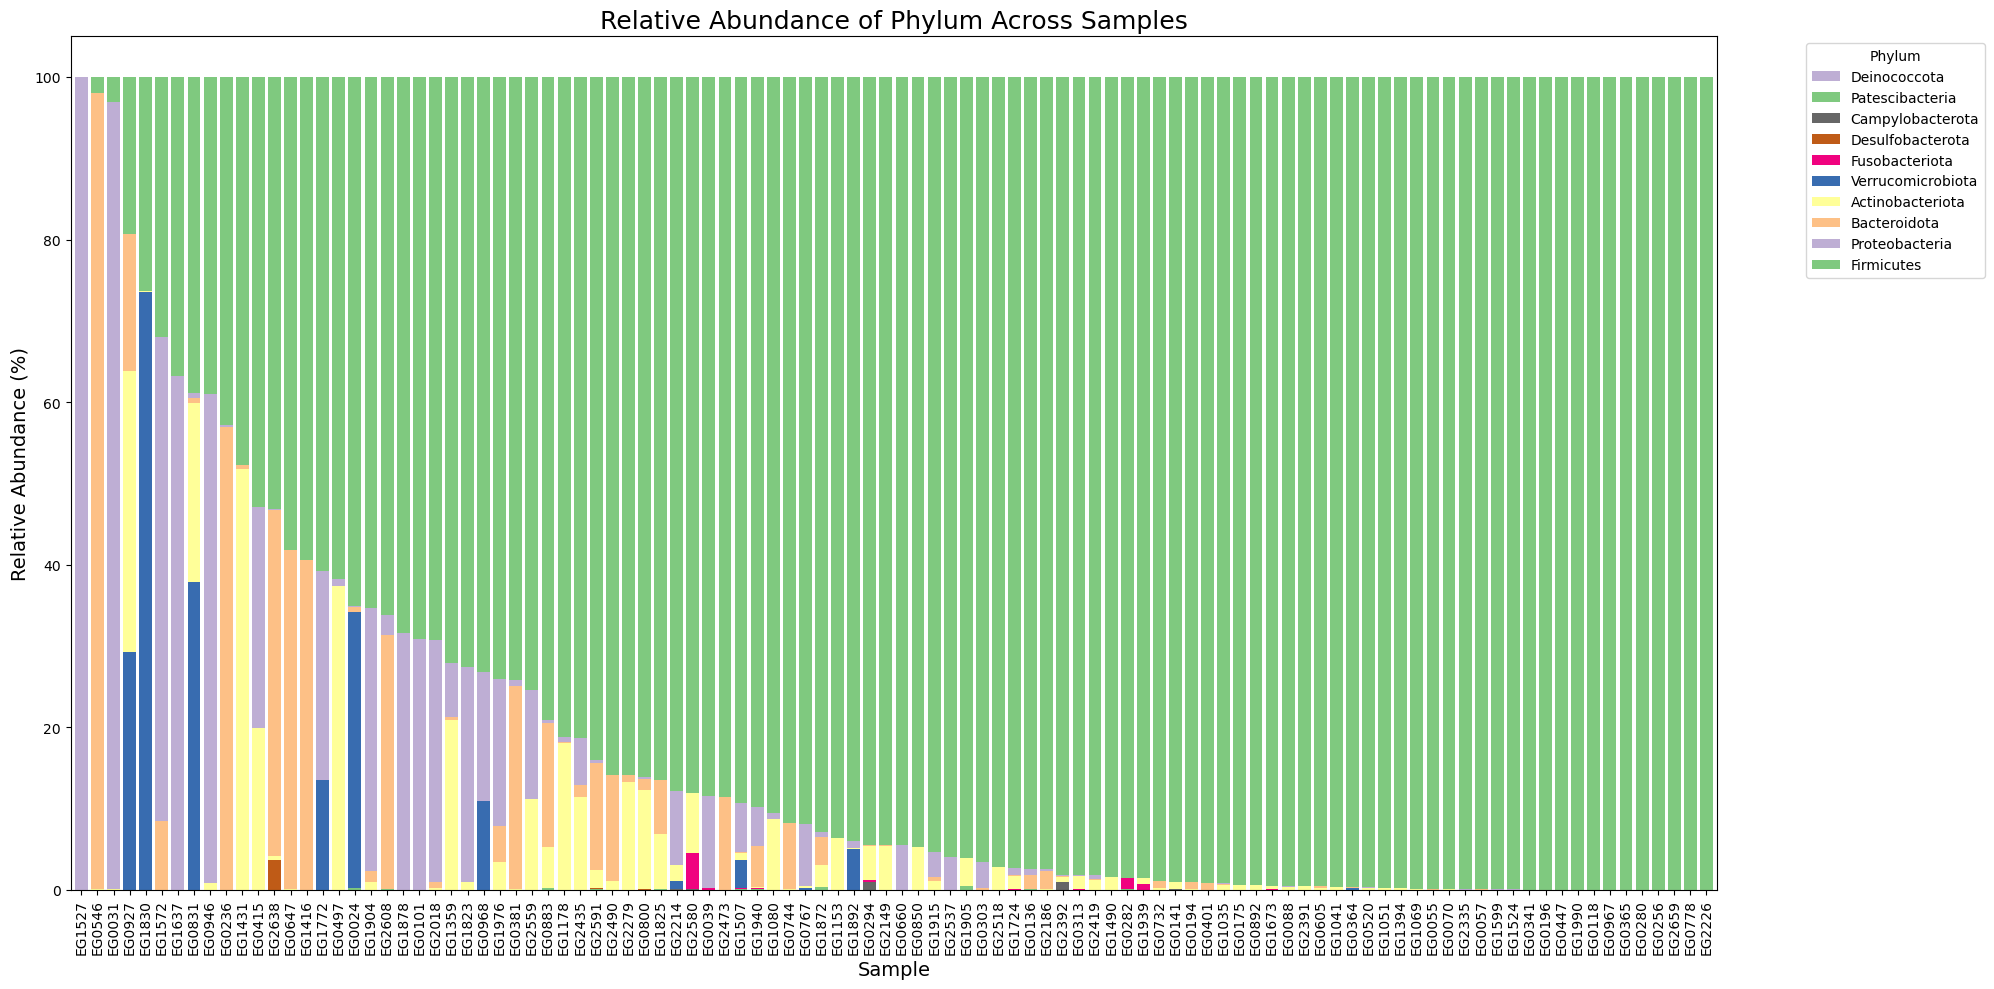

<Figure size 1500x800 with 0 Axes>

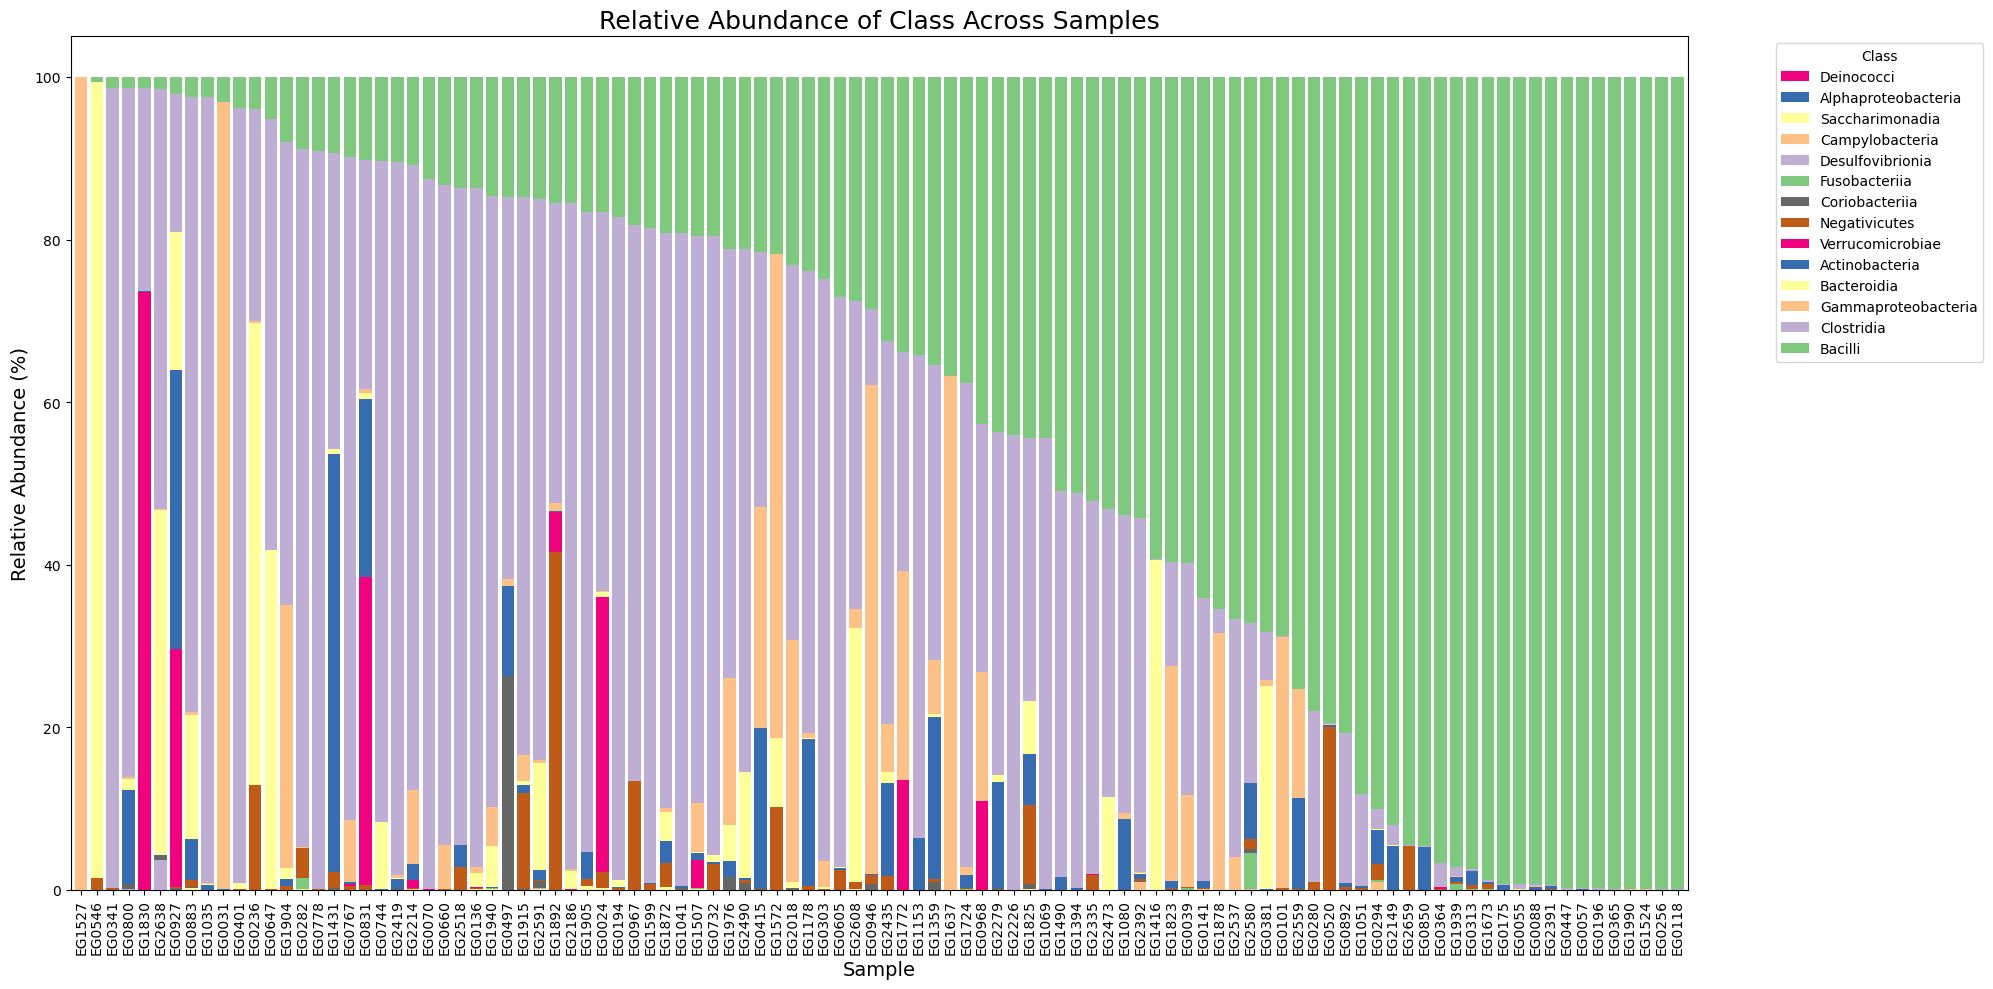

In [225]:
# ranks = ["Phylum", "Class", "Order", "Family", "Genus", "Species"]

ranks = ["Phylum", "Class"]

plot_taxonomic_abundance(df, ranks)

## Bibliography

[1] Michael S Robeson II, Devon R O'Rourke, Benjamin D Kaehler, Michal Ziemski, Matthew R Dillon, Jeffrey T Foster, Nicholas A Bokulich. 2021. "RESCRIPt: Reproducible sequence taxonomy reference database management". PLoS Computational Biology 17 (11): e1009581.; doi: 10.1371/journal.pcbi.1009581

[2] Pruesse, Elmar, Christian Quast, Katrin Knittel, Bernhard M. Fuchs, Wolfgang Ludwig, Jörg Peplies, and Frank Oliver Glöckner. 2007. “SILVA: A Comprehensive Online Resource for Quality Checked and Aligned Ribosomal RNA Sequence Data Compatible with ARB.” Nucleic Acids Research 35 (21): 7188–96. doi: 10.1093/nar/gkm864

[3] Quast, Christian, Elmar Pruesse, Pelin Yilmaz, Jan Gerken, Timmy Schweer, Pablo Yarza, Jörg Peplies, and Frank Oliver Glöckner. 2013. “The SILVA Ribosomal RNA Gene Database Project: Improved Data Processing and Web-Based Tools.” Nucleic Acids Research 41: D590–96. doi: 10.1093/nar/gks1219